<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install shap
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# We are going to import from the local path for models
# Because we are going to add more code 
import importlib
import sys
spec = importlib.util.spec_from_file_location("models", "finrl/agents/stablebaselines3/models.py")
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [7]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.478997,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.817791,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.300186,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.523602,7325600,CAT,0


In [8]:
df.tail()

,date,open,high,low,close,volume,tic,day
97008,2023-02-28,482.670013,483.359985,473.920013,468.880920,3902100,UNH,1
97009,2023-02-28,220.000000,221.770004,219.500000,218.634583,5385400,V,1
97010,2023-02-28,38.700001,38.970001,38.549999,36.722885,16685300,VZ,1
97011,2023-02-28,35.480000,35.779999,35.320000,33.584301,8847000,WBA,1
97012,2023-02-28,141.000000,142.649994,140.949997,139.994690,6018000,WMT,1


In [9]:
df.shape

(97013, 8)

In [10]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.478997,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.817791,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.300186,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.523602,7325600,CAT,0


In [11]:
len(df.tic.unique())

30

In [12]:
df.tic.value_counts()

tic
AAPL    3311
AMGN    3311
WMT     3311
WBA     3311
VZ      3311
V       3311
UNH     3311
TRV     3311
PG      3311
NKE     3311
MSFT    3311
MRK     3311
MMM     3311
MCD     3311
KO      3311
JPM     3311
JNJ     3311
INTC    3311
IBM     3311
HON     3311
HD      3311
GS      3311
DIS     3311
CVX     3311
CSCO    3311
CRM     3311
CAT     3311
BA      3311
AXP     3311
DOW      994
Name: count, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [13]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [14]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [15]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
40775,2015-08-05,175.529999,177.520004,175.380005,138.080811,2146700,AMGN,2,3.699073,141.388463,117.422208,62.457226,152.660162,35.668866,126.762649,125.623582,204.256722
6006,2010-10-28,71.300003,71.790001,70.349998,56.581619,4119800,BA,3,1.193316,58.083081,53.037451,58.754809,75.800564,15.744382,54.055419,52.515376,0.000000
82769,2021-05-06,229.300003,231.169998,226.550003,229.809998,11857100,BA,3,-3.735658,256.716383,224.297617,47.318967,-126.173015,31.840884,244.482333,238.045000,13.006900
93625,2022-10-28,28.180000,29.219999,27.860001,28.028425,91695700,INTC,4,-0.329536,27.553108,23.701210,48.025204,138.756485,6.810658,25.942281,28.937476,68.469375
65310,2018-12-13,107.769997,108.360001,106.330002,99.346153,3542600,AXP,3,0.097878,105.414225,96.627156,50.122393,-16.314959,0.073628,100.217636,99.316793,23.044143


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [16]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [17]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [18]:
# Adding the capability to set a fixed seed. 
# Set to None if you want to use random seed.
seed = 0

In [19]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = models.DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window,
                 seed=seed,
                 **env_kwargs)

In [20]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [21]:
torch.manual_seed(seed)
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  201.71835216321307
======Model training from:  2010-01-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
-------------------------------------
| time/                 |           |
|    fps                | 207       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | -0.213    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -2.78     |
|    reward             | -0.305413 |
|    std                | 1         |
|    value_loss         | 0.569     |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 21

In [22]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-10-04,2022-01-03,A2C,0.3088,0.246637,0.225574
1,189,2022-01-03,2022-04-04,PPO,-0.299518,-0.120754,-0.217203
2,252,2022-04-04,2022-07-06,PPO,-0.199171,-0.167406,-0.209183
3,315,2022-07-06,2022-10-04,DDPG,-0.138749,-0.211282,-0.103204


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [23]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [24]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.6845262463381331


In [25]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2022-01-03
1,1.000424e+06,2022-01-04,0.000424,2022-01-04
2,9.970307e+05,2022-01-05,-0.003392,2022-01-05
3,9.923901e+05,2022-01-06,-0.004654,2022-01-06
4,9.937816e+05,2022-01-07,0.001402,2022-01-07


<Axes: >

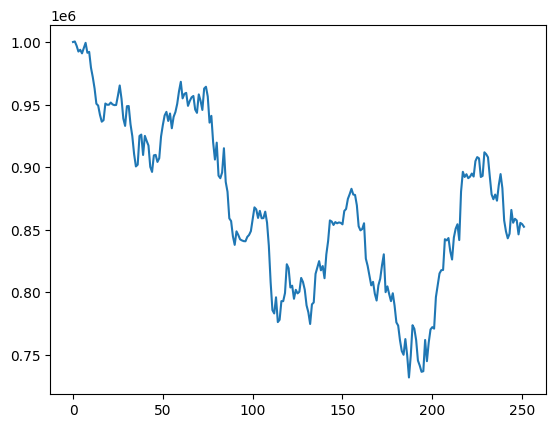

In [26]:
%matplotlib inline
df_account_value.account_value.plot()

In [27]:
df_account_value_averageaction=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('averageaction',i))
    df_account_value_averageaction = pd.concat([df_account_value_averageaction,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value_averageaction.account_value.pct_change(1).mean()/df_account_value_averageaction.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value_averageaction=df_account_value_averageaction.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.01795090497928968


In [28]:
df_account_value_averageaction.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2022-01-03
1,1.000691e+06,2022-01-04,0.000691,2022-01-04
2,9.987591e+05,2022-01-05,-0.001930,2022-01-05
3,9.985867e+05,2022-01-06,-0.000173,2022-01-06
4,9.992196e+05,2022-01-07,0.000634,2022-01-07


<Axes: >

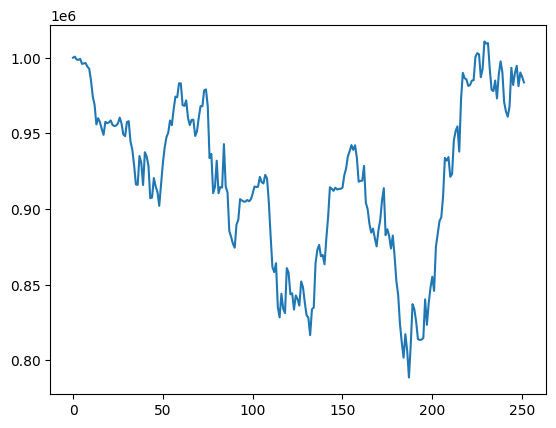

In [29]:
%matplotlib inline
df_account_value_averageaction.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [30]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
print("---------------------------------------------")
perf_stats_all_ = backtest_stats(account_value=df_account_value_averageaction)
perf_stats_all_ = pd.DataFrame(perf_stats_all_)

==============Get Backtest Results===========
Annual return         -0.147587
Cumulative returns    -0.147587
Annual volatility      0.203911
Sharpe ratio          -0.684526
Calmar ratio          -0.550072
Stability              0.383404
Max drawdown          -0.268304
Omega ratio            0.891643
Sortino ratio         -0.963173
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.977434
Daily value at risk   -0.026244
dtype: float64
---------------------------------------------
Annual return         -0.016324
Cumulative returns    -0.016324
Annual volatility      0.201235
Sharpe ratio           0.017951
Calmar ratio          -0.077043
Stability              0.020070
Max drawdown          -0.211877
Omega ratio            1.003121
Sortino ratio          0.026248
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.016302
Daily value at risk   -0.025339
dtype: float64


In [31]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return         -0.094324
Cumulative returns    -0.093968
Annual volatility      0.198502
Sharpe ratio          -0.402058
Calmar ratio          -0.429901
Stability              0.236972
Max drawdown          -0.219408
Omega ratio            0.936015
Sortino ratio         -0.559755
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014390
Daily value at risk   -0.025326
dtype: float64


In [32]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')
df_account_value_averageaction.to_csv('df_account_value_averageaction.csv')


df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.005866e+06
2    2022-01-05  9.951360e+05
3    2022-01-06  9.904718e+05
4    2022-01-07  9.903404e+05
..          ...           ...
247  2022-12-27  9.086102e+05
248  2022-12-28  8.986103e+05
249  2022-12-29  9.080428e+05
250  2022-12-30  9.060324e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2022-12-27  9.086102e+05
2022-12-28  8.986103e+05
2022-12-29  9.080428e+05
2022-12-30  9.060324e+05
2023-01-03           NaN

[252 rows x 1 columns]


<a id='6.2'></a>
## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_result_averageaction.columns:  Index(['averageaction'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  2023-02-27
352  2023-02-28

[353 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2022-01-03  1.000000e+06
2022-01-04  1.000424e+06
2022-01-05  9.970307e+05
2022-01-06  9.923901e+05
2022-01-07  9.937816e+05
...                  ...
2022-12-27  8.574674e+05
2022-12-28  8.463343e+05
2022-12-29  8.554932e+05
2022-12-30  8.545143e+05
2023-01-03  8.524135e+05

[252 rows x 1 columns]
df_result_averageaction:              averageaction
date                     
2022-01-03   1.000000e+06
2022-01-04   1.000691e+06
2022-01-05   9.987591e+05
2022-01-06   9.985867e+05
2022-01-07   9.992196e+05
...                   ...
2022-12-27   9.945961e+0

<Figure size 1500x500 with 0 Axes>

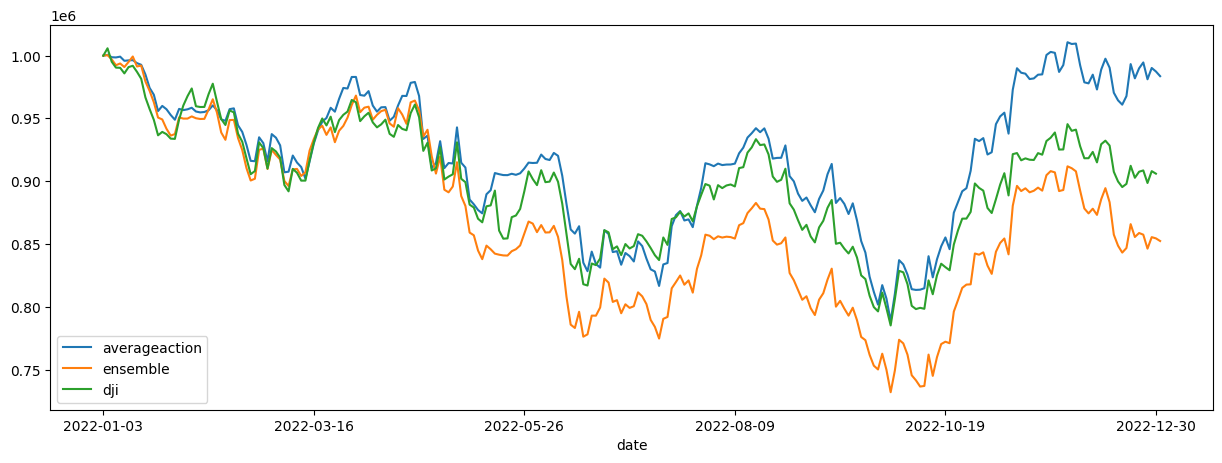

In [33]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#               baseline_ticker = '^DJI', 
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

df_result_averageaction = pd.DataFrame({'date': df_account_value_averageaction['date'], 
                                        'averageaction': df_account_value_averageaction['account_value']})
df_result_averageaction = df_result_averageaction.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)
print("df_result_averageaction.columns: ", df_result_averageaction.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
df_result_averageaction.to_csv("df_result_averageaction.csv")
print("df_result_averageaction: ", df_result_averageaction)

print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_averageaction, result, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['averageaction', 'ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

# Explain Ensemble Agent's Actions with SHAP

In [34]:
stock_trading_env = ensemble_agent.train_env.envs[0]

In [35]:
np.random.seed(0)
# randomly pick 1000 days from the training set as support for the kernel explainer
days = np.random.choice(processed.loc[pd.to_datetime(processed['date']) < datetime.datetime(2022, 1, 1), 
                                      'date'].unique(), 1000)

In [36]:
# use all days will take too long
# days = processed.loc[pd.to_datetime(processed['date']) < datetime.datetime(2022, 1, 1), 
#                                       'date']

In [37]:
# generate the state vectors of those days, however, we use static the initial portfolio value and there are no shares in portfolio
# this is because it is easier so we don't have run through the environment again
# granted this is not the exact explaination for each trading day in test set, it should be close
data_for_shap_tensor = []
for day in days:
  processed_on_date = processed.loc[processed['date'] == day]
  state = (
        [1e6]
        + processed_on_date.close.values.tolist()
        + stock_trading_env.num_stock_shares # this is a list of 0s
        + sum(
            (
                processed_on_date[tech].values.tolist()
                for tech in INDICATORS
            ),
            [],
        )
    )
  data_for_shap_tensor.append(state)
  
data_for_shap_tensor = np.array(data_for_shap_tensor)
data_for_shap_tensor.shape

(1000, 291)

In [38]:
import shap
import torch
def a2c_forward(input):
  torch.manual_seed(seed)
  with torch.no_grad():
    if torch.cuda.is_available():
      input_tensor = torch.from_numpy(input).to('cuda')
    else:
      input_tensor = torch.from_numpy(input)
    out = ensemble_agent.model_a2c.policy(input_tensor)
    return out[0].cpu().numpy()
  
def ppo_forward(input):
  torch.manual_seed(seed)
  with torch.no_grad():
    if torch.cuda.is_available():
      input_tensor = torch.from_numpy(input).to('cuda')
    else:
      input_tensor = torch.from_numpy(input)
    out = ensemble_agent.model_ppo.policy(input_tensor)
    return out[0].cpu().numpy()
  
def ddpg_forward(input):
  torch.manual_seed(seed)
  with torch.no_grad():
    if torch.cuda.is_available():
      input_tensor = torch.from_numpy(input).to('cuda')
    else:
      input_tensor = torch.from_numpy(input)
    out = ensemble_agent.model_ddpg.policy(input_tensor)
    return out.cpu().numpy()

### Explain 1 day

In [39]:
# our portfolio has big drawdown on 2022-12-09, we want to explain the trades on 2022-12-08
day = '2022-12-08'
processed_on_date = processed.loc[processed['date'] == day]
state = (
        [1e6]
        + processed_on_date.close.values.tolist()
        + stock_trading_env.num_stock_shares
        + sum(
            (
                processed_on_date[tech].values.tolist()
                for tech in INDICATORS
            ),
            [],
        )
    )
state = np.array(state).reshape(1,-1)

In [40]:
torch.manual_seed(seed)
a2c_explainer = shap.KernelExplainer(a2c_forward, data_for_shap_tensor)
# n_samples means how many times of random sampling of features to run to explain
a2c_shap_values = a2c_explainer.shap_values(state, n_samples=300)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1/1 [00:49<00:00, 49.35s/it]


In [41]:
torch.manual_seed(seed)
ppo_explainer = shap.KernelExplainer(ppo_forward, data_for_shap_tensor)
# n_samples means how many times of random sampling of features to run to explain
ppo_shap_values = ppo_explainer.shap_values(state, n_samples=300)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:45<00:00, 45.16s/it]


In [42]:
## issue with model_ddpg, states should have been normalized as zscores
with torch.no_grad():
    if torch.cuda.is_available():
      input_tensor = torch.from_numpy(state).to('cuda')
    else:
      input_tensor = torch.from_numpy(state)
    out = ensemble_agent.model_ddpg.actor(input_tensor)
out

tensor([[ 1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1.,
         -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,
         -1.]])

In [ ]:
# ddpg_explainer = shap.KernelExplainer(ddpg_forward, data_for_shap_tensor)
# n_samples means how many times of random sampling of features to run to explain
# ddpg_shap_values = ddpg_explainer.shap_values(state, n_samples=300)

100%|██████████| 1/1 [00:20<00:00, 20.90s/it]


In [43]:
input_tensor = torch.from_numpy(state).to('cpu')

In [44]:
torch.manual_seed(seed)
with torch.no_grad():
    out1 = ensemble_agent.model_a2c.policy(input_tensor)[0].numpy()

In [45]:
torch.manual_seed(seed)
with torch.no_grad():
    out2 = ensemble_agent.model_ppo.policy(input_tensor)[0].numpy()

In [46]:
np.corrcoef(out1, out2)

array([[1.        , 0.77390248],
       [0.77390248, 1.        ]])

In [47]:
out1

array([[-0.7604611 , -1.1547565 , -0.25969374,  0.4935727 ,  1.6570656 ,
         0.8974485 , -0.5034665 , -2.0446486 , -0.06702825, -2.276272  ,
         0.917964  , -0.48721308, -1.1972158 ,  0.55264276, -0.46133414,
        -0.10416685, -1.008407  ,  1.322255  , -0.83816767,  0.9592106 ,
         0.7609238 , -0.4605927 , -1.2837349 , -1.6496634 ,  1.7823699 ,
         0.64513123, -0.86766154,  0.81681734,  0.5145797 ]],
      dtype=float32)

In [48]:
out2

array([[-1.1657032e+00, -1.2233930e+00, -2.8689265e-01, -5.0023115e-01,
         7.8211164e-01,  7.3185647e-01, -3.5864973e-01, -2.1869102e+00,
         3.1712905e-01, -1.2161745e+00,  2.4894539e-01,  6.4509541e-02,
         1.0558287e-01,  8.9595908e-01, -2.6732868e-01, -1.5113486e-01,
        -6.4372313e-01, -1.4509577e-03, -4.5633891e-01,  3.8584417e-01,
         3.5229647e-01, -3.5806039e-01, -8.4684956e-01, -2.3405988e+00,
        -4.6061367e-02,  8.6822712e-01, -2.4502860e-01,  7.3517770e-02,
         4.9854043e-01]], dtype=float32)

In [49]:
shap.initjs()
tickers_sorted = sorted(df['tic'].unique())
tickers_sorted.remove('DOW')
feature_list = ['close', 'shares'] + INDICATORS
col_names = ['balance'] + [f'{ticker}_close' for ticker in tickers_sorted] + [f'{ticker}_shares' for ticker in tickers_sorted] + [f'{ticker}_{indicator}' for indicator in INDICATORS for ticker in tickers_sorted]

stock = 15
print(f"Given stock to explain: {tickers_sorted[stock]}")
# plot explanation for a specific stock index in the a2c agent
shap.force_plot(a2c_explainer.expected_value[stock], a2c_shap_values[stock], feature_names=col_names)

Given stock to explain: JPM


In [50]:
# plot explanation for a specific stock index in the ppo agent
print(f"Given stock to explain: {tickers_sorted[stock]}")
shap.force_plot(ppo_explainer.expected_value[stock], ppo_shap_values[stock], feature_names=col_names)

Given stock to explain: JPM


### Explain multiple days

In [ ]:
# explain last 20 days (2022 december)
days = processed.loc[(pd.to_datetime(processed['date']) > datetime.datetime(2022, 1, 1)) &
                     (pd.to_datetime(processed['date']) < datetime.datetime(2023, 1, 1)), 
                                      'date'].unique()
days = days[-126:]

data_multi_days_tensor = []
for day in days:
  processed_on_date = processed.loc[processed['date'] == day]
  state = (
        [1e6]
        + processed_on_date.close.values.tolist()
        + stock_trading_env.num_stock_shares # this is a list of 0s
        + sum(
            (
                processed_on_date[tech].values.tolist()
                for tech in INDICATORS
            ),
            [],
        )
    )
  data_multi_days_tensor.append(state)
  
data_multi_days_tensor = np.array(data_multi_days_tensor)
data_multi_days_tensor.shape

(126, 291)

In [ ]:
days

array(['2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08',
       '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
       '2022-07-15', '2022-07-18', '2022-07-19', '2022-07-20',
       '2022-07-21', '2022-07-22', '2022-07-25', '2022-07-26',
       '2022-07-27', '2022-07-28', '2022-07-29', '2022-08-01',
       '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05',
       '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11',
       '2022-08-12', '2022-08-15', '2022-08-16', '2022-08-17',
       '2022-08-18', '2022-08-19', '2022-08-22', '2022-08-23',
       '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-29',
       '2022-08-30', '2022-08-31', '2022-09-01', '2022-09-02',
       '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09',
       '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15',
       '2022-09-16', '2022-09-19', '2022-09-20', '2022-09-21',
       '2022-09-22', '2022-09-23', '2022-09-26', '2022-09-27',
       '2022-09-28', '2022-09-29', '2022-09-30', '2022-

In [ ]:
# explain all the predictions in the test set
torch.manual_seed(seed)
a2c_explainer = shap.KernelExplainer(a2c_forward, data_for_shap_tensor)
a2c_shap_values_multi_days = a2c_explainer.shap_values(data_multi_days_tensor, n_samples=100)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 126/126 [1:39:16<00:00, 47.27s/it]


In [ ]:
import pickle
file_name = 'a2c_shap_values_multi_days.pkl'

# Dumping the list to a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(a2c_shap_values_multi_days, file)

In [ ]:
# np.save('a2c_shap_values_multi_days.npy', np.array(a2c_shap_values_multi_days))
# load_list = np.load('a2c_shap_values_multi_days.npy')

Summary plot for stock INTC


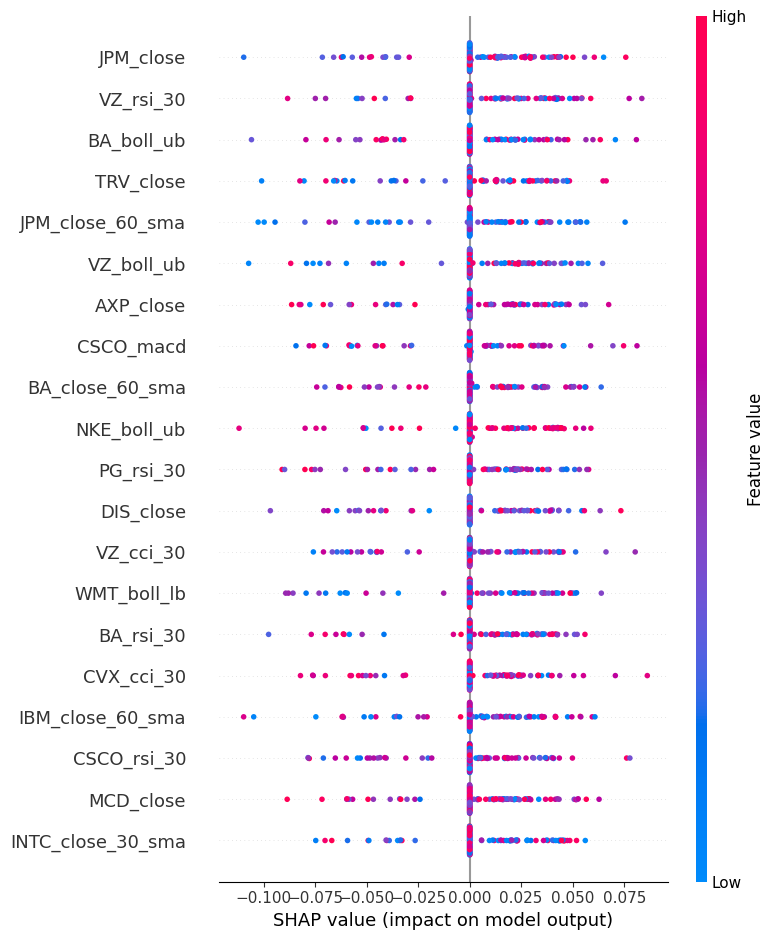

In [ ]:
idx = 13
print(f"Summary plot for stock {tickers_sorted[idx]}")
shap.summary_plot(a2c_shap_values_multi_days[idx], data_multi_days_tensor, feature_names=col_names)

In [ ]:
shap.force_plot(a2c_explainer.expected_value[0], a2c_shap_values_multi_days[0], data_multi_days_tensor, feature_names=col_names)